### Import necessary module

In [3]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.datasets import cifar100
import time

### Data pre-processing

In [4]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [5]:
print(X_train.shape)
number_of_sample = 20
first_twenty = []
for i in range(number_of_sample):
  first_twenty.append(i)

mask = np.isin(y_train, first_twenty)
y_train_all = y_train[mask]
X_train_all = X_train[mask.squeeze()]


mask = np.isin(y_test, first_twenty)
X_test = X_test[mask.squeeze()]
y_test = y_test[mask]
print(X_train.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)


In [6]:
X_train, y_train = X_train_all[ : int(len(X_train_all) * 0.9)], y_train_all[ : int(len(X_train_all) * 0.9)]
X_val, y_val = X_train_all[int(len(X_train_all) * 0.9) : ], y_train_all[int(len(X_train_all) * 0.9) : ]

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(9000, 32, 32, 3) (9000,)
(2000, 32, 32, 3) (2000,)
(1000, 32, 32, 3) (1000,)


In [8]:
def preprocess(images, label):
  images = tf.image.resize(images, [224, 224])
  images = images / 255.0
  return images, label

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
def inference_time(model, X_val_resized):

  start_time = time.time()
  predictions = model.predict(X_val_resized)
  end_time = time.time()

  inference_time = end_time - start_time

  return inference_time

### Model - 1. VGG16

In [14]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
vgg16.trainable = False

x = vgg16.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(vgg16.input, outputs, name = 'VGG16')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 59s 201ms/step - accuracy: 0.0515 - loss: 3.0070 - val_accuracy: 0.0430 - val_loss: 2.9964
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 202ms/step - accuracy: 0.0526 - loss: 2.9973 - val_accuracy: 0.0410 - val_loss: 2.9972
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.0521 - loss: 2.9958 - val_accuracy: 0.0410 - val_loss: 2.9974
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.0524 - loss: 2.9958 - val_accuracy: 0.0410 - val_loss: 2.9978
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - accuracy: 0.0503 - loss: 2.9959 - val_accuracy: 0.0410 - val_loss: 2.9980
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step
Inference time: 10.4609 seconds


In [15]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.0488 - loss: 2.9961
Training Accuracy: 0.0468
Training Loss: 2.9960
Validation Accuracy: 0.0410
Validation Loss: 2.9980
Test Accuracy: 0.0500
Test Loss: 2.9958


### Model - 2. VGG19

In [22]:
from tensorflow.keras.applications import VGG19

vgg19 = VGG19(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
vgg19.trainable = False
x = vgg19.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(vgg19.input, outputs, name = 'VGG19')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 69s 236ms/step - accuracy: 0.0504 - loss: 3.0489 - val_accuracy: 0.0450 - val_loss: 2.9966
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 84s 248ms/step - accuracy: 0.0548 - loss: 2.9958 - val_accuracy: 0.0450 - val_loss: 2.9970
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 72s 254ms/step - accuracy: 0.0544 - loss: 2.9959 - val_accuracy: 0.0350 - val_loss: 2.9976
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - accuracy: 0.0534 - loss: 2.9957 - val_accuracy: 0.0410 - val_loss: 2.9979
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 70s 246ms/step - accuracy: 0.0548 - loss: 2.9958 - val_accuracy: 0.0350 - val_loss: 2.9979
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step
Inference time: 8.0746 seconds


In [21]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.0421 - loss: 2.9959
Training Accuracy: 0.0462
Training Loss: 3.0087
Validation Accuracy: 0.0430
Validation Loss: 2.9965
Test Accuracy: 0.0500
Test Loss: 2.9958


### Model - 3. DenseNet121

In [23]:
from tensorflow.keras.applications import DenseNet121

densenet = DenseNet121(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
densenet.trainable = False
x = densenet.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(densenet.input, outputs, name = 'DensNet121')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 91s 217ms/step - accuracy: 0.0566 - loss: 3.2453 - val_accuracy: 0.0730 - val_loss: 2.8607
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - accuracy: 0.0944 - loss: 2.8251 - val_accuracy: 0.0940 - val_loss: 2.7594
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.1001 - loss: 2.7544 - val_accuracy: 0.0960 - val_loss: 2.7312
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.1068 - loss: 2.7003 - val_accuracy: 0.0990 - val_loss: 2.7110
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.1178 - loss: 2.6384 - val_accuracy: 0.1180 - val_loss: 2.6625
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 462ms/step
Inference time: 40.9883 seconds


In [24]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.1216 - loss: 2.6328
Training Accuracy: 0.1196
Training Loss: 2.6303
Validation Accuracy: 0.1180
Validation Loss: 2.6625
Test Accuracy: 0.1195
Test Loss: 2.6613


### Model - 4. MobileNetV2

In [11]:
from tensorflow.keras.applications import MobileNetV2

mobilenetV2 = MobileNetV2(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
mobilenetV2.trainable = False
x = mobilenetV2.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(mobilenetV2.input, outputs, name = 'MobileNetV2')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

/tmp/ipython-input-239586597.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetV2 = MobileNetV2(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 60s 146ms/step - accuracy: 0.1133 - loss: 3.2035 - val_accuracy: 0.1640 - val_loss: 2.5910
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.1970 - loss: 2.4944 - val_accuracy: 0.1620 - val_loss: 2.6603
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.2136 - loss: 2.3944 - val_accuracy: 0.2040 - val_loss: 2.5206
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.2321 - loss: 2.2674 - val_accuracy: 0.1960 - val_loss: 2.4321
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.2601 - loss: 2.1822 - val_accuracy: 0.1910 - val_loss: 2.5138
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step
Inference time: 10.2779 seconds


In [12]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.2425 - loss: 2.3784
Training Accuracy: 0.2576
Training Loss: 2.1699
Validation Accuracy: 0.1910
Validation Loss: 2.5138
Test Accuracy: 0.2360
Test Loss: 2.3598


### Model - 5. ResNet50

In [13]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
resnet.trainable = False
x = resnet.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(resnet.input, outputs, name = 'ResNet50')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.0481 - loss: 3.4531 - val_accuracy: 0.0350 - val_loss: 2.9965
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.0566 - loss: 2.9959 - val_accuracy: 0.0350 - val_loss: 2.9971
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - accuracy: 0.0497 - loss: 2.9958 - val_accuracy: 0.0410 - val_loss: 2.9976
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.0530 - loss: 2.9959 - val_accuracy: 0.0350 - val_loss: 2.9978
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.0524 - loss: 2.9960 - val_accuracy: 0.0410 - val_loss: 2.9981
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step
Inference time: 20.6890 seconds


In [14]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.0488 - loss: 2.9961
Training Accuracy: 0.0489
Training Loss: 2.9960
Validation Accuracy: 0.0410
Validation Loss: 2.9981
Test Accuracy: 0.0500
Test Loss: 2.9959


### Model-6. NasaNetMobile

In [15]:
from tensorflow.keras.applications import NASNetMobile

nasnetmobile = NASNetMobile(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
nasnetmobile.trainable = False
x = nasnetmobile.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(nasnetmobile.input, outputs, name = 'NasaNetMobile')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 129s 307ms/step - accuracy: 0.2434 - loss: 2.7917 - val_accuracy: 0.3940 - val_loss: 1.9751
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.5052 - loss: 1.6339 - val_accuracy: 0.5410 - val_loss: 1.6080
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.6435 - loss: 1.1775 - val_accuracy: 0.6500 - val_loss: 1.4214
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.7365 - loss: 0.8612 - val_accuracy: 0.6730 - val_loss: 1.4254
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.7943 - loss: 0.6557 - val_accuracy: 0.6560 - val_loss: 1.4044
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 739ms/step
Inference time: 43.1550 seconds


In [16]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.6702 - loss: 1.2864
Training Accuracy: 0.7892
Training Loss: 0.6292
Validation Accuracy: 0.6560
Validation Loss: 1.4044
Test Accuracy: 0.6890
Test Loss: 1.2547


### Model-7. ResNet101

In [17]:
from tensorflow.keras.applications import ResNet101

resnet101 = ResNet101(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
resnet101.trainable = False
x = resnet101.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(resnet101.input, outputs, name = 'ResNet101')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.0506 - loss: 3.2482 - val_accuracy: 0.0500 - val_loss: 2.9963
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 61s 175ms/step - accuracy: 0.0473 - loss: 2.9960 - val_accuracy: 0.0450 - val_loss: 2.9969
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.0426 - loss: 2.9959 - val_accuracy: 0.0450 - val_loss: 2.9974
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 174ms/step - accuracy: 0.0499 - loss: 2.9959 - val_accuracy: 0.0490 - val_loss: 2.9976
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.0517 - loss: 2.9959 - val_accuracy: 0.0410 - val_loss: 2.9979
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step
Inference time: 19.9797 seconds


In [18]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.0488 - loss: 2.9960
Training Accuracy: 0.0499
Training Loss: 2.9960
Validation Accuracy: 0.0410
Validation Loss: 2.9979
Test Accuracy: 0.0500
Test Loss: 2.9958


### Model-8. Xception

In [19]:
from tensorflow.keras.applications import Xception

xception = Xception(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
xception.trainable = False
x = xception.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(xception.input, outputs, name = 'Xception')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 204ms/step - accuracy: 0.4050 - loss: 2.2531 - val_accuracy: 0.6600 - val_loss: 1.3315
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.6947 - loss: 1.0651 - val_accuracy: 0.6780 - val_loss: 1.2342
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - accuracy: 0.7826 - loss: 0.7117 - val_accuracy: 0.7350 - val_loss: 1.2426
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.8381 - loss: 0.4920 - val_accuracy: 0.7420 - val_loss: 1.2407
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - accuracy: 0.8705 - loss: 0.3988 - val_accuracy: 0.7470 - val_loss: 1.3286
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step
Inference time: 20.5069 seconds


In [20]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.7518 - loss: 1.4129
Training Accuracy: 0.8723
Training Loss: 0.3864
Validation Accuracy: 0.7470
Validation Loss: 1.3286
Test Accuracy: 0.7620
Test Loss: 1.2798


### Model -9.InceptionV3

In [21]:
from tensorflow.keras.applications import InceptionV3

inceptionV3 = InceptionV3(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
inceptionV3.trainable = False
x = inceptionV3.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(inceptionV3.input, outputs, name = 'InceptionV3')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - accuracy: 0.0944 - loss: 3.9752 - val_accuracy: 0.1350 - val_loss: 2.7093
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.1522 - loss: 2.6421 - val_accuracy: 0.1480 - val_loss: 2.5655
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.1764 - loss: 2.5160 - val_accuracy: 0.1790 - val_loss: 2.5208
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.2022 - loss: 2.3519 - val_accuracy: 0.1910 - val_loss: 2.4904
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.2247 - loss: 2.2582 - val_accuracy: 0.2160 - val_loss: 2.4602
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step
Inference time: 20.5671 seconds


In [22]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.2132 - loss: 2.5985
Training Accuracy: 0.2283
Training Loss: 2.2433
Validation Accuracy: 0.2160
Validation Loss: 2.4602
Test Accuracy: 0.2150
Test Loss: 2.5520


### Model-10. ConvNextBase

In [23]:
from tensorflow.keras.applications import ConvNeXtBase

convnextbase = ConvNeXtBase(input_tensor = Input(shape=(224, 224, 3)), weights='imagenet', include_top=False)
convnextbase.trainable = False
x = convnextbase.output
x = Flatten()(x)
x = Dense(32, activation = 'relu', name = 'Dense-layer')(x)
outputs = Dense(20, activation = 'softmax', name = 'output-layer')(x)
model = Model(convnextbase.input, outputs, name = 'ResNet')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset)

X_val_resized = tf.image.resize(X_val, (224, 224))

predictions = inference_time(model, X_val_resized)
print(f"Inference time: {predictions:.4f} seconds")

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 152s 454ms/step - accuracy: 0.0505 - loss: 3.6429 - val_accuracy: 0.0450 - val_loss: 2.9966
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 121s 415ms/step - accuracy: 0.0474 - loss: 2.9958 - val_accuracy: 0.0390 - val_loss: 2.9971
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 107s 378ms/step - accuracy: 0.0507 - loss: 2.9958 - val_accuracy: 0.0450 - val_loss: 2.9975
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 117s 413ms/step - accuracy: 0.0550 - loss: 2.9958 - val_accuracy: 0.0410 - val_loss: 2.9977
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 142s 414ms/step - accuracy: 0.0463 - loss: 2.9958 - val_accuracy: 0.0430 - val_loss: 2.9981
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 532ms/step
Inference time: 24.3132 seconds


In [24]:
final_epoch = -1  # last epoch

train_loss = history.history['loss'][final_epoch]
train_accuracy = history.history['accuracy'][final_epoch]
val_loss = history.history['val_loss'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - accuracy: 0.0528 - loss: 2.9961
Training Accuracy: 0.0483
Training Loss: 2.9959
Validation Accuracy: 0.0430
Validation Loss: 2.9981
Test Accuracy: 0.0500
Test Loss: 2.9959


### Accuracy and Loss

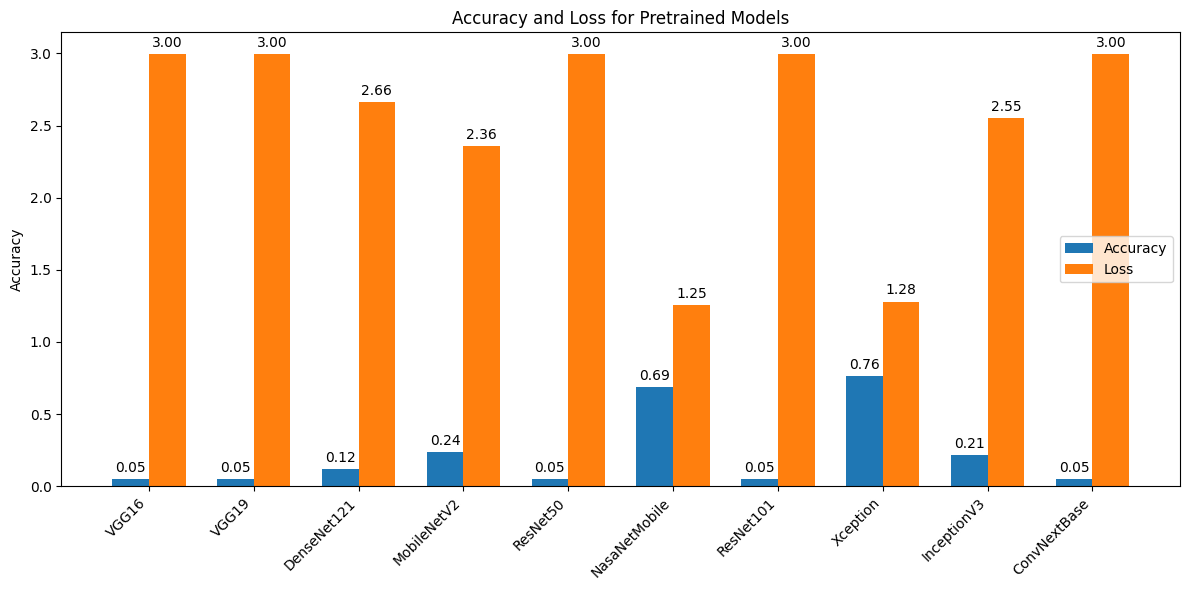

In [25]:
import matplotlib.pyplot as plt
import numpy as np

models = ["VGG16", "VGG19", "DenseNet121", "MobileNetV2", "ResNet50",
          "NasaNetMobile", "ResNet101", "Xception", "InceptionV3", "ConvNextBase"]

accuracy = [0.0500, 0.0500, 0.1195, 0.2360, 0.0500, 0.6890, 0.0500, 0.7620, 0.2150, 0.0500]
loss     = [2.9958, 2.9958, 2.6613, 2.3598, 2.9959, 1.2547, 2.9958, 1.2798, 2.5520, 2.9959]

# X locations for groups
x = np.arange(len(models))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Bars for accuracy and loss
rects1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
rects2 = ax.bar(x + width/2, loss, width, label='Loss')

# Labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy and Loss for Pretrained Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

# Function to add values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


### Inference time

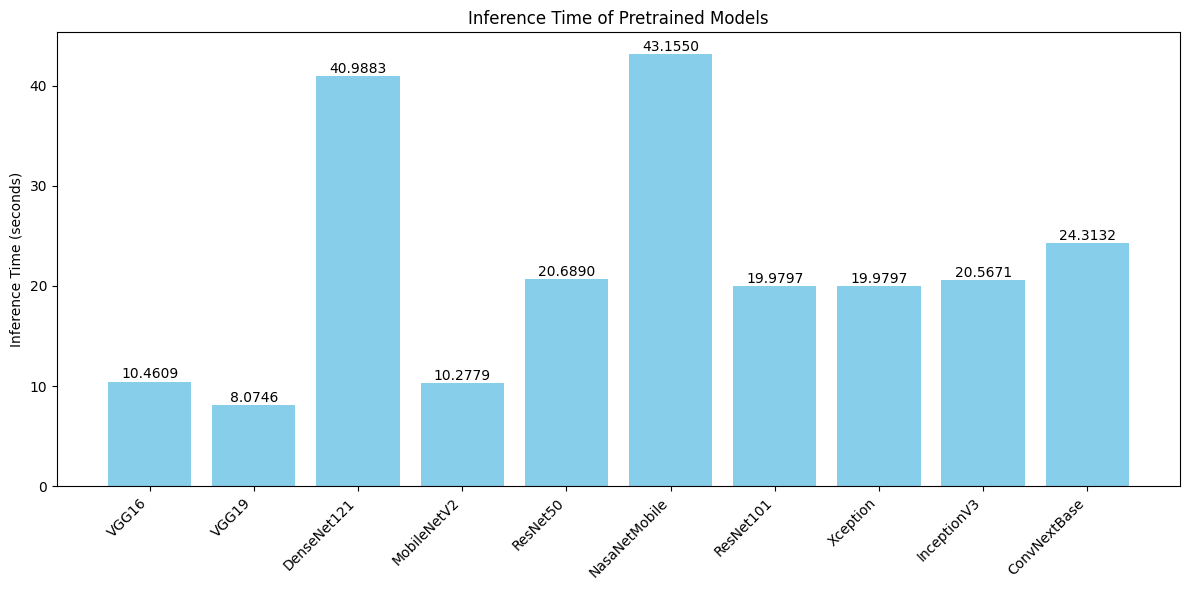

In [26]:
import matplotlib.pyplot as plt

model_names = ["VGG16", "VGG19", "DenseNet121", "MobileNetV2", "ResNet50",
          "NasaNetMobile", "ResNet101", "Xception", "InceptionV3", "ConvNextBase"]

inference_times = [10.4609, 8.0746, 40.9883, 10.2779, 20.6890,
                   43.1550, 19.9797, 19.9797, 20.5671, 24.3132]  # <-- replace with your values

# Plot bar chart
plt.figure(figsize=(12,6))
bars = plt.bar(model_names, inference_times, color="skyblue")

# Add labels
plt.ylabel("Inference Time (seconds)")
plt.title("Inference Time of Pretrained Models")
plt.xticks(rotation=45, ha="right")

# Add values on top of each bar
for bar, t in zip(bars, inference_times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f"{t:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
